In [1]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
from scipy.signal import convolve2d
import copy

In [2]:
########## Problem 2 #############
# Read input data
train, test = [], []
for i in range(1, 41):
    for j in range(1, 7):
        train.append(cv2.imread("./p2_data/{}_{}.png".format(i, j), cv2.IMREAD_GRAYSCALE))
    for j in range(7, 11):
        test.append(cv2.imread("./p2_data/{}_{}.png".format(i, j), cv2.IMREAD_GRAYSCALE))

In [3]:
def image_to_array(imgs):
    res = []
    for img in imgs:
        row, col = img.shape
        array = []    
        for r in range(row):
            for c in range(col):
                array.append(img[r][c])
        res.append(array)

    return np.array(res, dtype=np.float64)

In [4]:
# Transform each image into a row in an array
X_train = image_to_array(train)
X_test = image_to_array(test)

Y_train = np.array([i for i in range(1, 41) for _ in range(1, 7)])
Y_test = np.array([i for i in range(1, 41) for _ in range(1,5)])

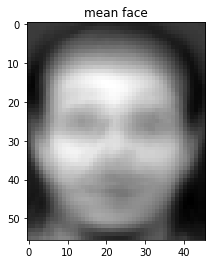

In [5]:
########## 2-1 start #############
# Mean face
mean = np.mean(X_train, axis=0)
plt.title("mean face")
plt.imshow(np.resize(mean, (56,46)), cmap='gray')
plt.imsave("mean face", np.resize(mean, (56,46)), cmap='gray')
plt.show()

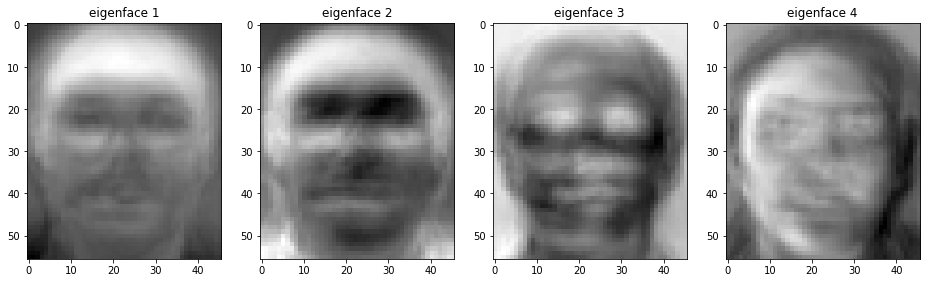

In [6]:
# PCA
pca = PCA()
pca.fit(X_train-mean)

# Each row in pca.components_ is an eigenvector
eigenfaces = np.empty((0, 56*46))
row, col = pca.components_.shape
for r in range(row):
    eigenfaces = np.vstack((eigenfaces, pca.components_[r]))

# First four eigenfaces
plt.figure(figsize=(16,12))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.title("eigenface {}".format(i+1))
    plt.imshow(np.resize(eigenfaces[i], (56,46)), cmap='gray')
    plt.imsave("eigenface {}".format(i+1), np.resize(eigenfaces[i], (56,46)), cmap='gray')
plt.show()

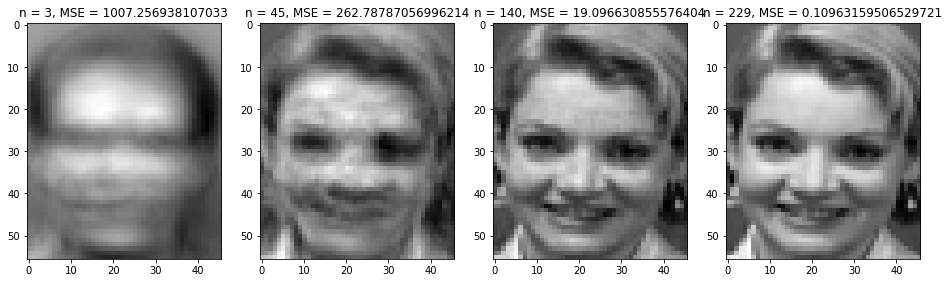

In [7]:
########## 2-2 start #############
# Project x into eigenspace
x = X_train[0] - mean
y = pca.transform(np.resize(x, (1,2576))) # Resize into a single row

# Reconstruct with n = 3, 45, 140, 229
numbers_of_faces = [3, 45, 140, 229]
plt.figure(figsize=(16,12))
for index, n in enumerate(numbers_of_faces):
    face = mean
    for i in range(n):
        face = face + y[0][i] * eigenfaces[i]
    
    # Calculate MSE
    loss = X_train[0] - face
    mse = np.mean(loss ** 2)
    
    plt.subplot(1, 4, index+1)
    plt.title("n = {}, MSE = {}".format(n, mse))
    plt.imsave("reconstructed {}".format(n), np.resize(face, (56,46)), cmap='gray')
    plt.imshow(np.resize(face, (56,46)), cmap='gray')
plt.show()

In [8]:
########## 2-3 start #############
# Reduce the dimensions of the training data
reduced_X_train = pca.transform(X_train-mean)

K = [1, 3, 5] # K neighbors
N = [3, 45, 140] # dimensions


print("\t\tn=3\t\tn=45\t\t\tn=140")
for k in K:
    # Create a KNN model
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = []
    
    for n in N:
        # Train the model with cv of 3 
        cv_scores = cross_val_score(knn, reduced_X_train[:, 0:n], Y_train, cv=3)
        scores.append(np.mean(cv_scores))
        
    print("k = {} {}".format(k, scores))

		n=3		n=45			n=140
k = 1 [0.7041666666666666, 0.9291666666666666, 0.9291666666666667]
k = 3 [0.6166666666666666, 0.8583333333333334, 0.8583333333333334]
k = 5 [0.5208333333333334, 0.7916666666666666, 0.7541666666666665]


In [9]:
########## 2-4 start #############
# Best hyperparameters
k = 1
n = 140

# Reduce the dimensions of the testing data
reduced_X_test = pca.transform(X_test-mean)
# shape = (160, 240)

knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(reduced_X_train[:, 0:n], Y_train)

print("The acc is {}".format(knn.score(reduced_X_test[:, 0:n], Y_test)))

The acc is 0.9375


In [10]:
########## Problem 3 #############
# Read input data
category = ["banana", "fountain", "reef", "tractor"]
X_train, X_test = [], []
Y_train, Y_test = [], []
for i in range(4):
    for j in range(1, 376):
        src = cv2.imread("./p3_data/{}/{}_{}.jpeg".format(category[i], category[i], str(j).zfill(3)))
        X_train.append(cv2.cvtColor(src, cv2.COLOR_BGR2RGB))
        Y_train.append(i)
    for j in range(376, 501):
        src = cv2.imread("./p3_data/{}/{}_{}.jpeg".format(category[i], category[i], str(j).zfill(3)))
        X_test.append(cv2.cvtColor(src, cv2.COLOR_BGR2RGB))
        Y_test.append(i)

In [11]:
def image_to_patch(img):
    row, col, height = img.shape
    patch_size = row // 4
    
    patch = []
    for r in range(0, row, patch_size):
        for c in range(0, col, patch_size):
            patch.append(img[r:r+patch_size, c:c+patch_size].flatten())
            
    return patch

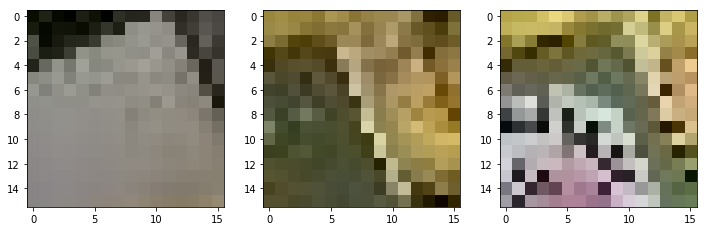

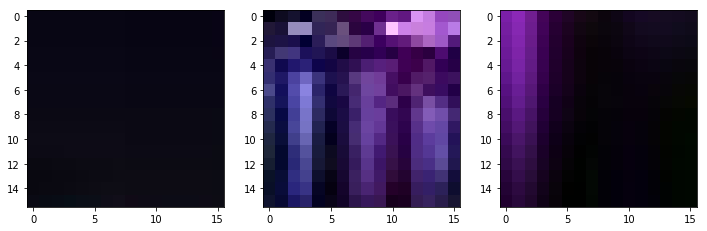

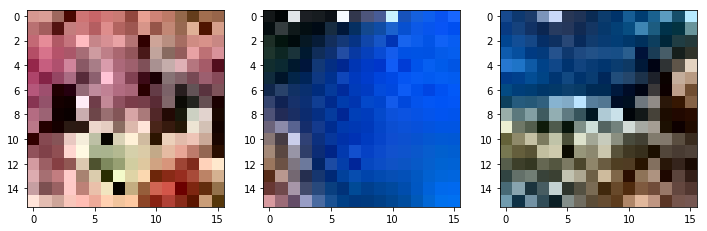

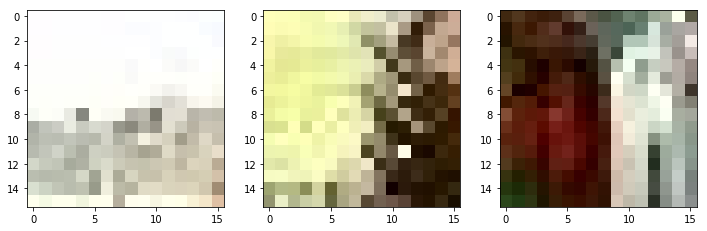

In [12]:
########## 3-1 Start #############
# Randomly choose 1 image from the category
number = 169
imgs = []
for i in range(4):
    src = cv2.imread("./p3_data/{}/{}_{}.jpeg".format(category[i], category[i], str(number).zfill(3)))
    imgs.append(cv2.cvtColor(src, cv2.COLOR_BGR2RGB))
    
# Transform each image into multiple patches in a array
patches = []
for i in range(4):
    patches.append(image_to_patch(imgs[i]))
patches = np.array(patches)

# Randomly choose 3 patches from the image
patch_number = [0, 8, 15]
for i in range(4):
    plt.figure(figsize=(12,9))
    for index, pn in enumerate(patch_number):
        plt.subplot(1, 3, index+1)
        plt.imshow(np.resize(patches[i][pn], (16 ,16, 3)))
        plt.imsave("{}_{}".format(i,index), np.resize(patches[i][pn], (16 ,16, 3)))
    plt.show()

In [13]:
# Transform each image into multiple patches in an array
X_train_patches, X_test_patches = [], []
for i in range(1500):
    X_train_patches.extend(image_to_patch(X_train[i]))
for i in range(500):
    X_test_patches.extend(image_to_patch(X_test[i]))

X_train_patches = np.array(X_train_patches)
X_test_patches = np.array(X_test_patches)

In [14]:
########## 3-2 Start #############
# Kmeans clustering on the training data
C = 15
iteration = 5000

kmeans = KMeans(n_clusters=C, max_iter=iteration, random_state=0)
kmeans.fit(X_train_patches)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=5000,
    n_clusters=15, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

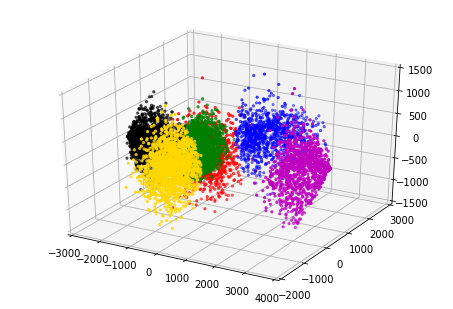

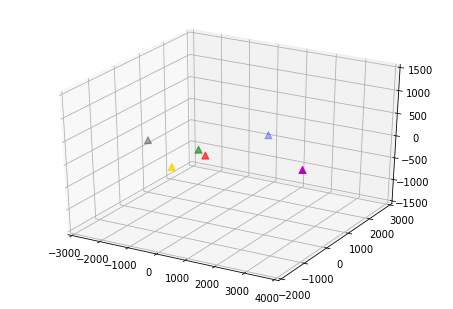

In [15]:
# PCA
mean = np.mean(X_train_patches, axis=0)
pca = PCA(n_components=3)
reduced_X_train = pca.fit_transform(X_train_patches-mean)
reduced_center = pca.transform(kmeans.cluster_centers_-mean)

# Sort the data according to the label
sorted_Y = kmeans.labels_[kmeans.labels_.argsort()]
sorted_X = reduced_X_train[kmeans.labels_.argsort()]

count = [0 for i in range(15)]
for num in sorted_Y:
    count[num] += 1

size = 0
for i in range(6):
    size += count[i]

# Plot the 3D figure of the 6 chosen clusters 
color = ['r', 'g', 'b', 'k', 'gold', 'm']
label_to_color = [color[label] for label in sorted_Y[:size]]

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(sorted_X[:size, 0], sorted_X[:size, 1], sorted_X[:size, 2], c=label_to_color, s=5)

ax.set_xlim([-3000, 4000])
ax.set_ylim([-2000, 3000])
ax.set_zlim([-1500, 1500])


fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(reduced_center[:6, 0], reduced_center[:6, 1], reduced_center[:6, 2], c=color, marker="^", s=50)

ax.set_xlim([-3000, 4000])
ax.set_ylim([-2000, 3000])
ax.set_zlim([-1500, 1500])

plt.show()

In [16]:
########## 3-3 Start #############
centers = kmeans.cluster_centers_

BoW = []
for i in range(1500):
    table = []
    # Convert each image to 16 patches
    patches = np.array(image_to_patch(X_train[i]))
    # Create a 16*15 table of distance between patches and centers
    for patch in patches:
        patch_and_dist = []
        for center in centers:
            patch_and_dist.append(np.linalg.norm(patch-center))
            
        table.append(patch_and_dist)
        
    # Normalize the reciprocal of each row
    table = np.reciprocal(table)
    for r in range(table.shape[0]):
        table[r] = table[r] / np.sum(table[r])
    
    BoW.append(np.amax(table, axis=0))
BoW = np.array(BoW)

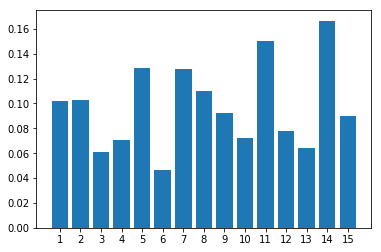

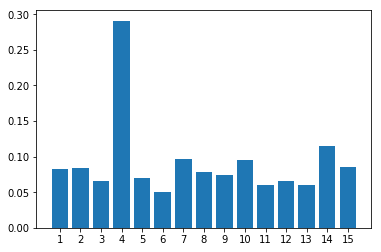

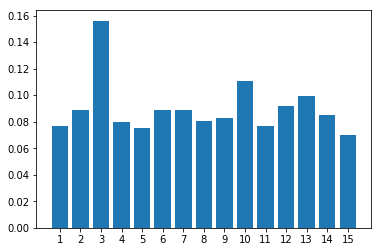

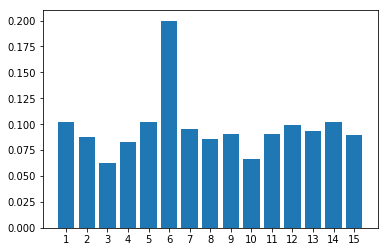

In [17]:
# Visualize images
number = 169
x_axis = [i+1 for i in range(15)]
for r in range(0, 1500, 375):
    y_axis = BoW[r+number-1]    
    plt.bar(x_axis, y_axis)
    plt.xticks(x_axis)
    plt.show()

In [18]:
########## 3-4 Start #############
BoW_test = []
for i in range(500):
    table = []
    # Convert each image to 16 patches
    patches = np.array(image_to_patch(X_test[i]))
    # Create a 16*15 table of distance between patches and centers
    for patch in patches:
        patch_and_dist = []
        for center in centers:
            patch_and_dist.append(np.linalg.norm(patch-center))
            
        table.append(patch_and_dist)
        
    # Normalize the reciprocal of each row
    table = np.reciprocal(table)
    for r in range(table.shape[0]):
        table[r] = table[r] / np.sum(table[r])
    
    BoW_test.append(np.amax(table, axis=0))
BoW_test = np.array(BoW_test)

In [19]:
# KNN
k=5
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(BoW, Y_train)

print("The acc is {}".format(knn.score(BoW_test, Y_test)))

The acc is 0.514


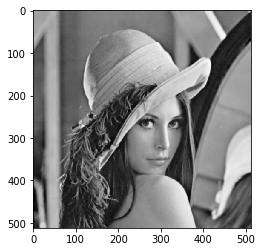

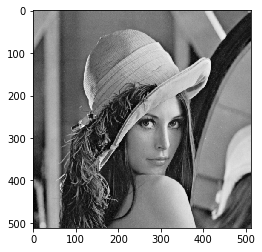

In [30]:
########## Problem 4 #############
########## 4-2 Start #############
sigma = 1 / (2*np.log(2))
img = cv2.imread("./lena.png", cv2.IMREAD_GRAYSCALE)

# Gaussian filter
x, y = np.mgrid[-1:2, -1:2]
mask = np.exp(-(x**2+y**2)/(2*sigma*sigma)) / (2*np.pi*sigma)
mask = mask / np.sum(mask)

result = convolve2d(img, mask, mode='same')
plt.imshow(result, cmap='gray')
plt.imsave("gaussian_lena.png", result, cmap='gray')
plt.show()
plt.imshow(img, cmap='gray')
plt.show()

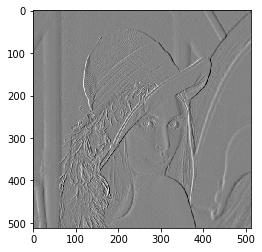

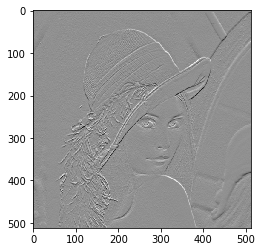

In [31]:
########## 4-3 Start #############
index = [-1, 0, 1]
mask = [-0.5, 0, 0.5]

row, col = img.shape

# Ix
Ix = np.zeros((row, col))
for r in range(row):
    for c in range(1, col-1):
        Ix[r][c] = -0.5*img[r][c-1] + 0.5*img[r][c+1]

plt.imshow(Ix, cmap='gray')    
plt.imsave("Ix.png",Ix, cmap='gray')
plt.show()

# Iy
Iy = np.zeros((row, col))
for c in range(col):
    for r in range(1, row-1):
        Iy[r][c] = -0.5*img[r-1][c] + 0.5*img[r+1][c]

plt.imshow(Iy, cmap='gray')
plt.imsave("Iy.png", Iy, cmap='gray')
plt.show()

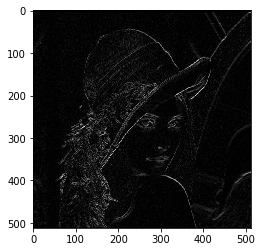

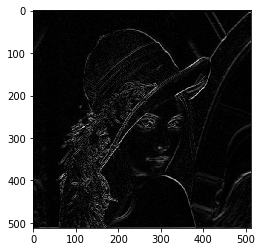

In [32]:
########## 4-4 Start #############
img1 = cv2.imread("./lena.png", cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread("./gaussian_lena.png", cv2.IMREAD_GRAYSCALE)

row, col = img1.shape

Ix = np.zeros((row, col))
for r in range(row):
    for c in range(1, col-1):
        Ix[r][c] = -0.5*img1[r][c-1] + 0.5*img1[r][c+1]
Ix = np.zeros((row, col))
for c in range(col):
    for r in range(1, row-1):
        Iy[r][c] = -0.5*img1[r-1][c] + 0.5*img1[r+1][c]

result_img1 = Ix = np.zeros((row, col))
for r in range(row):
    for c in range(col):
        result_img1[r][c] = np.sqrt(Ix[r][c]**2 + Iy[r][c]**2)

plt.imshow(result_img1, cmap='gray')
plt.imsave("result_img1.png", result_img1, cmap='gray')
plt.show()


Ix = Ix = np.zeros((row, col))
for r in range(row):
    for c in range(1, col-1):
        Ix[r][c] = -0.5*img2[r][c-1] + 0.5*img2[r][c+1]
Iy = Ix = np.zeros((row, col))
for c in range(col):
    for r in range(1, row-1):
        Iy[r][c] = -0.5*img2[r-1][c] + 0.5*img2[r+1][c]

result_img2 = Ix = np.zeros((row, col))
for r in range(row):
    for c in range(col):
        result_img2[r][c] = np.sqrt(Ix[r][c]**2 + Iy[r][c]**2)

plt.imshow(result_img2, cmap='gray')
plt.imsave("result_img2.png", result_img2, cmap='gray')
plt.show()